# Introduction to the existing Eurec$^4$a Simulations

Hauke Schulz has put considerable effort into making the Dataset available. This includes `zarr` files, publicly available via https on the DKRZ swift browser and an `intake` catalog. Although the `intake` catalog is neither complete (3D fields missing, as of 14. Juli 2022) nor perfect (e.g. [this (now resolved) issue](https://github.com/eurec4a/eurec4a-intake/issues/103)) it facilitates access to the data, making it possible to work with it from outside the levante system. There is also [documentation on the simulations](https://howto.eurec4a.eu/icon_les.html), written by Hauke.


In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')
# add my repo to module_path
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
from function_timer import function_timer

# Setup

The simulation setup consists of three nested domains `DOM01` (624m equivalent square cell edge length), `DOM02` (312m) and `DOM03` (156m). The outer domain `DOM01` is forced by the output of an ICON Storm-resolving simulation (SRM) via boundary conditions. Inner domains are nested by outer domains (e.g. `DOM01` forces `DOM02`). For this reasons they are started with delay to have a short spin up for the outer domain, before the inner domains starts with forcing by the outer domain. `DOM03` has been configured but was neglegted and output is only available for `DOM01` and `DOM02`.

Rough domain boundaries and position in the North Atlantic trade wind region:

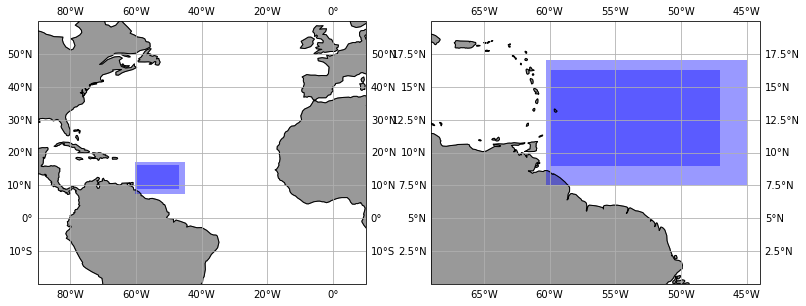

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import cartopy.feature as cfeature
import numpy as np
import plot_utils as pu

def rectangle(grid):
    lonlim = [np.rad2deg(l) for l in (np.min(grid.clon.values), np.max(grid.clon.values))]
    latlim = [np.rad2deg(l) for l in (np.min(grid.clat.values), np.max(grid.clat.values))]
    anker  = (lonlim[0], latlim[0]) # Rectangle demands coordinates for lower left corner + height and width
    extent = (lonlim[1] - lonlim[0], latlim[1] - latlim[0])
    return Rectangle(anker, *extent)

def add_map_view(ax, map_projection, latlon_limits, colored_map=False, gridlines=True):
    # decorations
    ax.coastlines()
    if colored_map:
        # (https://techoverflow.net/2021/04/25/how-to-add-colored-background-to-cartopy-map/)
        ax.stock_img()
    else:
        # or just color the land:
        ax.add_feature(cfeature.LAND, facecolor='black', alpha=0.4)
    ax.set_extent(latlon_limits, ccrs.PlateCarree())
    if gridlines:
        ax.gridlines(draw_labels=True, crs=map_projection)

def add_rectangles(ax, rectangles):
    # Create patch collection with specified colour/alpha, inside the loop, because it can not be reused
    pc = PatchCollection(rectangles, facecolor='blue', alpha=0.4, edgecolor=None)    
    ax.add_collection(pc)
    
def eureca_domain_rectangles(domains=['DOM01','DOM02'],):
    # get extents of grids as rectangles
    rectangles = list()
    for dom in ['DOM01','DOM02']:
        grid = xr.open_zarr(f"https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_{dom}.zarr")
        rectangles.append(rectangle(grid))
    return rectangles
    
def plot_grid_rectangles(latlon_limit_list):
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=[20, 10])
    axs = list()

    for i, latlon_limit in enumerate(latlon_limit_list): 
        ax = fig.add_subplot(1, len(latlon_limit_list)+1, i+1, projection=projection)
        add_map_view(ax, projection, latlon_limit)
        add_rectangles(ax, eureca_domain_rectangles())
        axs.append(ax)

    return fig, axs

  
fig, axs = plot_grid_rectangles([ (-90,+10,-20,+60), (-69,-44,+0,+20)])
pu.savefig(fig, 'img/eurec4a_domain_maps.png')
plt.show()

The simulations use the NWP physics implementation with a two moment microphysics scheme. The number of cloud condensation nuclei (CCN) in this scheme follows a profile with constant high values in the mixed layer, an exponential decay above and a constant low concentrations in higher altitudes. This profile does not adapt to the model state, but is hard coded. This lead to somewhat accidental creation of both a control run and a high CCN run. While not intended, the high CCN run seems to better fit observations concerning rain frequency and distribution as well as mesoscale patterns (pers.comm. Hauke Schulz).

In [27]:
import eurec4a

# get grid
dom = 'DOM01'
cat = eurec4a.get_intake_catalog()['simulations']
grid_id = cat['ICON']['LES_CampaignDomain_control'][f'surface_{dom}'].to_dask().uuidOfHGrid
grid    = cat['grids'][grid_id].to_dask()
# domain extent in radians
span = { key : np.max(grid[key].values) - np.min(grid[key].values) for key in ['vlat', 'vlon']}
# span in kilometer
earth_radius = 6371 # km 
for key, value in span.items(): print(f'{key}: {value*earth_radius:.0f} km')

vlat: 1060 km
vlon: 1700 km


In [29]:
import eurec4a
cat = eurec4a.get_intake_catalog()
data = cat.simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()

To see the actual data you can use the [gridlook tool](https://tobi.pages.gwdg.de/gridlook/#https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/json_eurec4a_sim_time.json) by Tobias Kölling.

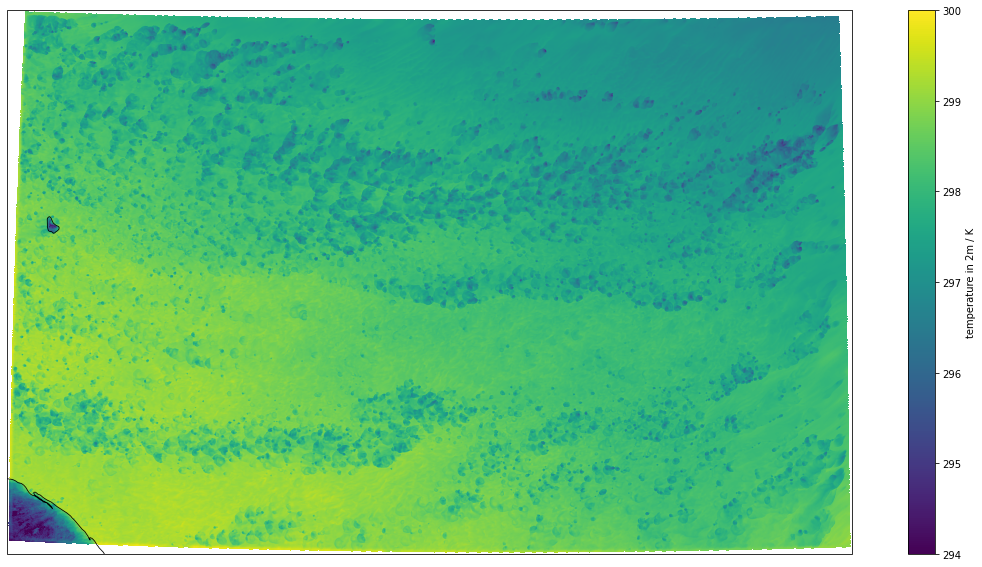

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datashader
from datashader.mpl_ext import dsshow
import cartopy.crs as ccrs
import cartopy.feature as cf

data = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/EUREC4A_LES/experiment_2/ICON_DOM01_surface.zarr")
grid = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/grids/EUREC4A_PR1250m_DOM01.zarr")

central_longitude = -51.12929041262429
central_latitude = 13.752618396747945
satellite_height = 12397842.405331613

vmin = 294; vmax = 300
cmap = "viridis"
t = 3429
variable = data["t_2m"].isel(time=t)

projection = ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height)
coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon),
    np.rad2deg(grid.clat),
)

fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(20,10))
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.8)

artist = dsshow(
    pd.DataFrame({ "val": variable.values, "x": coords[:, 0], "y": coords[:, 1],}),
    datashader.Point('x', 'y'), datashader.mean('val'),
    vmin=vmin, vmax=vmax,
    cmap=cmap, ax=ax,
)
fig.colorbar(artist, label=f"{variable.long_name} / {variable.units}")
filename = f'./img/{variable.standard_name}_{t}.png'
fig.savefig(filename, bbox_inches="tight")

The output has some irregularities in the first few hours of the simulation, but was written uniformly for most of the model run time.

# The Data
The available data comprises: surface data, 3D fields, simulated synthetic satellite images  (rttov) and meteograms for several stations:

In [4]:
import eurec4a
import xarray as xr

cat = eurec4a.get_intake_catalog()

print('Available simulations:', ', '.join(list(cat.simulations.ICON)) )
print('Datasets in control simulation:\n\t', ',\n\t'.join(list(cat.simulations.ICON.LES_CampaignDomain_control)) )

Available simulations: LES_CampaignDomain_highCCN, LES_CampaignDomain_control, SRM
Datasets in control simulation:
	 surface_DOM01,
	surface_DOM02,
	surface_DOM03,
	effective_radius_DOM01,
	effective_radius_DOM02,
	effective_radius_DOM03,
	rttov_DOM01,
	rttov_DOM02,
	3D_DOM01,
	3D_DOM02,
	3D_DOM03,
	pressure_lev_DOM03,
	radiation_DOM01,
	radiation_DOM02,
	meteogram_BCO_DOM01,
	synthetic_radar_BCO_DOM01,
	meteogram_BCO_DOM02,
	synthetic_radar_BCO_DOM02,
	meteogram_NTAS_DOM01,
	synthetic_radar_NTAS_DOM01,
	meteogram_NTAS_DOM02,
	synthetic_radar_NTAS_DOM02,
	meteogram_NTAS_DOM03,
	synthetic_radar_NTAS_DOM03,
	meteogram_c_center_DOM01,
	synthetic_radar_c_center_DOM01,
	meteogram_c_center_DOM02,
	synthetic_radar_c_center_DOM02,
	meteogram_c_center_DOM03,
	synthetic_radar_c_center_DOM03,
	meteogram_c_east_DOM01,
	synthetic_radar_c_east_DOM01,
	meteogram_c_east_DOM02,
	synthetic_radar_c_east_DOM02,
	meteogram_c_east_DOM03,
	synthetic_radar_c_east_DOM03,
	meteogram_c_north_DOM01,
	synthetic_ra

Data was written out with frequencies ranging from 1m (meteograms) to 3h (3D fields).

In [5]:
for name in ['surface_DOM01', 'rttov_DOM01', 'meteogram_BCO_DOM01', 'synthetic_radar_c_north_DOM01', '3D_DOM01']:
    t = cat.simulations.ICON.LES_CampaignDomain_control[name].to_dask().time.values
    print(f'{name}, output every {np.timedelta64(t[11] - t[10],"m").astype(int)} minutes')

surface_DOM01, output every 5 minutes
rttov_DOM01, output every 10 minutes
meteogram_BCO_DOM01, output every 1 minutes
synthetic_radar_c_north_DOM01, output every 1 minutes
3D_DOM01, output every 180 minutes


The output is continous for the largest part of the simulation:

Function 'timelineplot' executed in 14.0134s


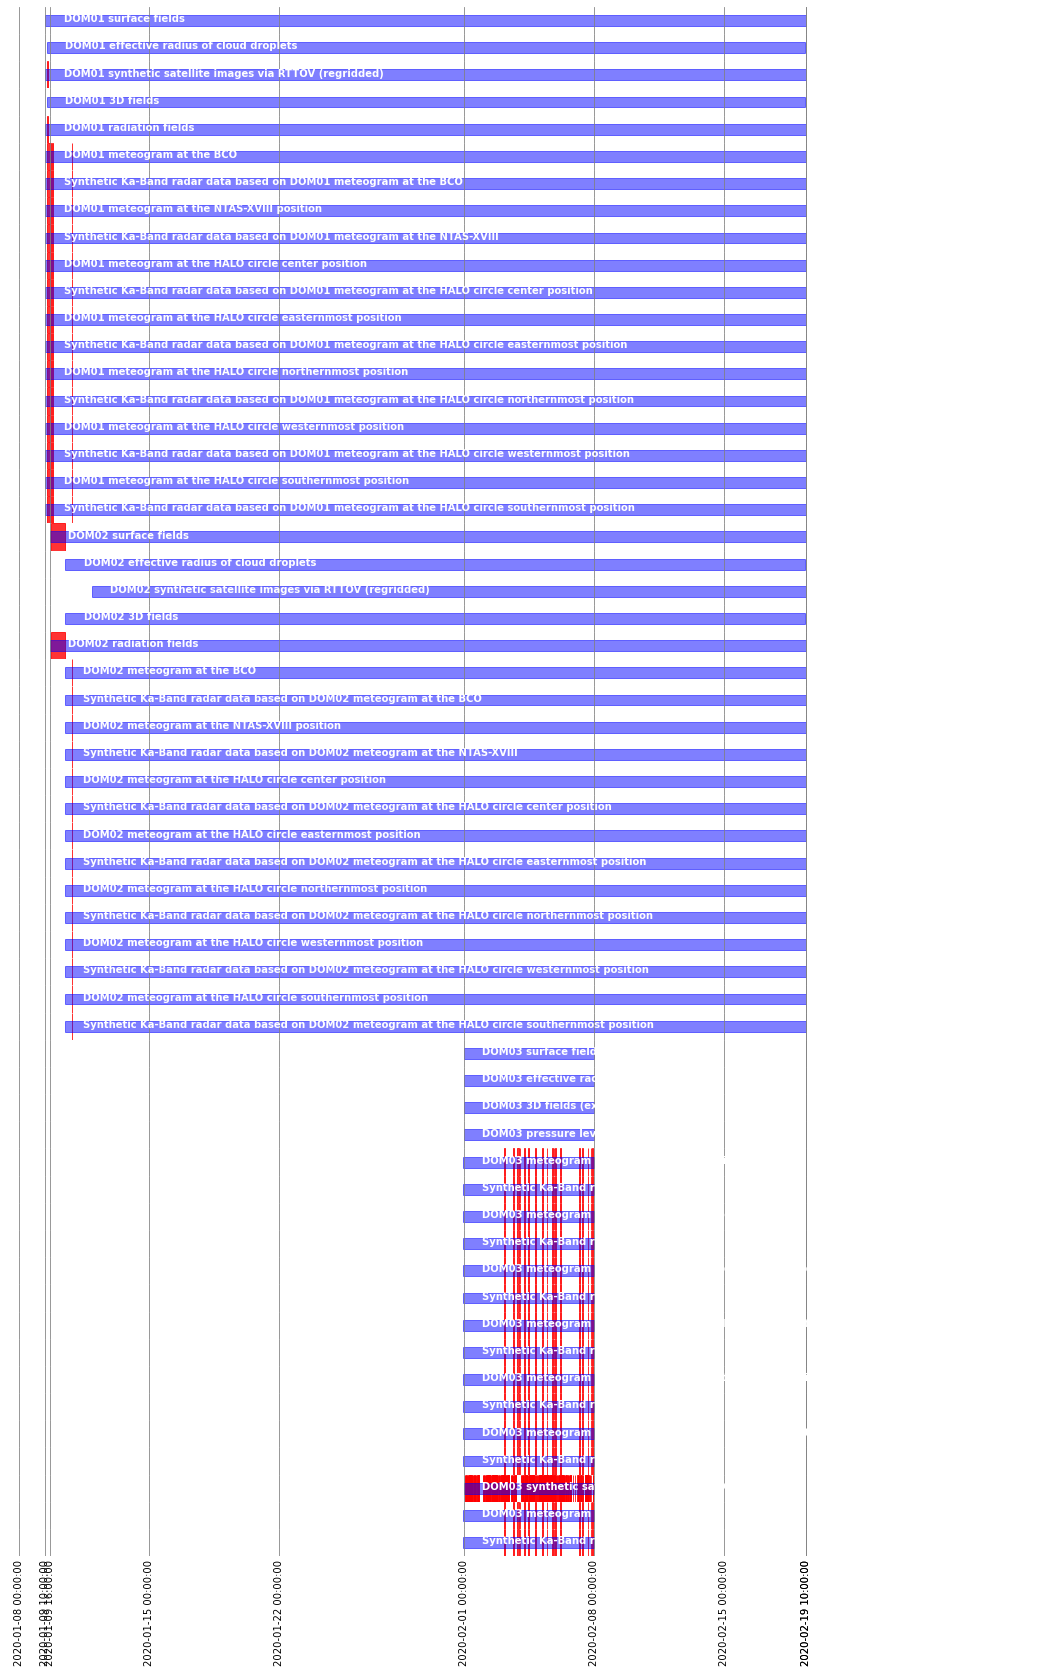

In [14]:
import eurec4a
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.gridspec as mgridspec


def extraticks():
    extraticks = []
    for s in ds:
        t = ctrl[s].to_dask().time.values[0]
        extraticks.append(mdates.date2num(t))
    for s in ['surface_DOM01', 'surface_DOM02']:
        t = ctrl[s].to_dask().time.values[-1]
        extraticks.append(mdates.date2num(t))
    return extraticks
    

@function_timer
def timelineplot():
    verbose = False

    ctrl = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control
    datasets  = [label for label in list(ctrl) if 'DOM01' in label]
    datasets += [label for label in list(ctrl) if 'DOM02' in label]
    datasets += [label for label in list(ctrl) if 'DOM03' in label]
    
    nrow = len(datasets)
    ncol = 1
    scaling = 0.5 # for figure size
    figsize = (30*scaling,nrow*scaling)
    fig, axs = plt.subplots(nrow,ncol, figsize=figsize, sharex=True)
    # remove padding between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    
    
    # we want to add the starting times of DOM01 and DOM02 to the plot
    extraticks = []
    for s in ['surface_DOM01', 'surface_DOM02']:
        t = ctrl[s].to_dask().time.values[0]
        extraticks.append(mdates.date2num(t))
    for s in ['surface_DOM01', 'surface_DOM02']:
        t = ctrl[s].to_dask().time.values[-1]
        extraticks.append(mdates.date2num(t))
    extraticks
    
    
    
    for i,d in enumerate(datasets):
        time  = ctrl[d].to_dask().time.values
        label = ctrl[d].description

        # check if time steps are equally spaced (timed)
        deltas = time[1::] - time[0:-1]
        if verbose:
            if np.min(deltas) < np.median(deltas):
                print(f'{label}:\n    min to small: {np.min(deltas)/np.median(deltas)} * mean')
            if np.max(deltas) > np.median(deltas):
                print(f'{label}:\n    max to big: {np.max(deltas)/np.median(deltas)} * mean')

        # plot
        ax = axs[i]
        color = 'blue'

        # for immaculate time series:
        if np.min(deltas) == np.mean(deltas) and np.max(deltas) == np.mean(deltas):
            ax.axvspan(time[0], time[-1], 0.3, 0.7, color=color, alpha=0.5)
        # for irregularities in the time series: 
        else:
            # mark interval
            irregular = np.where(deltas != np.median(deltas))[0]
            for x in irregular:
                ax.axvspan(time[x-1],time[x+1],color='red', alpha=0.8, lw=1)
            ax.axvspan(time[0], time[-1], 0.3, 0.7, color=color, alpha=0.5)

        # place a text label in the middle of the plot
        offset = np.timedelta64(1, 'D')
        ax.text(time[0]+offset, 0.45, label, fontweight='bold', fontdict=None, color='white')

        if i == 0: # only once: get ticks and add extraticks (times of DOM01 and DOM02 start)
            ticks = [*extraticks, *list(ax.get_xticks())]
            ticks.sort()
            ticks = np.asarray(ticks)
        # always: add these new ticks
        ax.set_xticks(ticks)
        # rotate ticks
        ax.tick_params(axis="x", rotation=90)
        # date format of tick labels
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

        # remove borders
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
        # remove y ticks
        ax.set_yticks([], [])
        # add grid
        ax.grid(axis='x')
        # make ticks invisible, but dont remove them, because we need them for the grid.
        ax.tick_params(length=0, grid_color = 'grey')
        # remove ticklabels from every bot the last ax
        if i > (len(axs) -1): ax.get_xaxis().set_visible(False)
        
timelineplot()

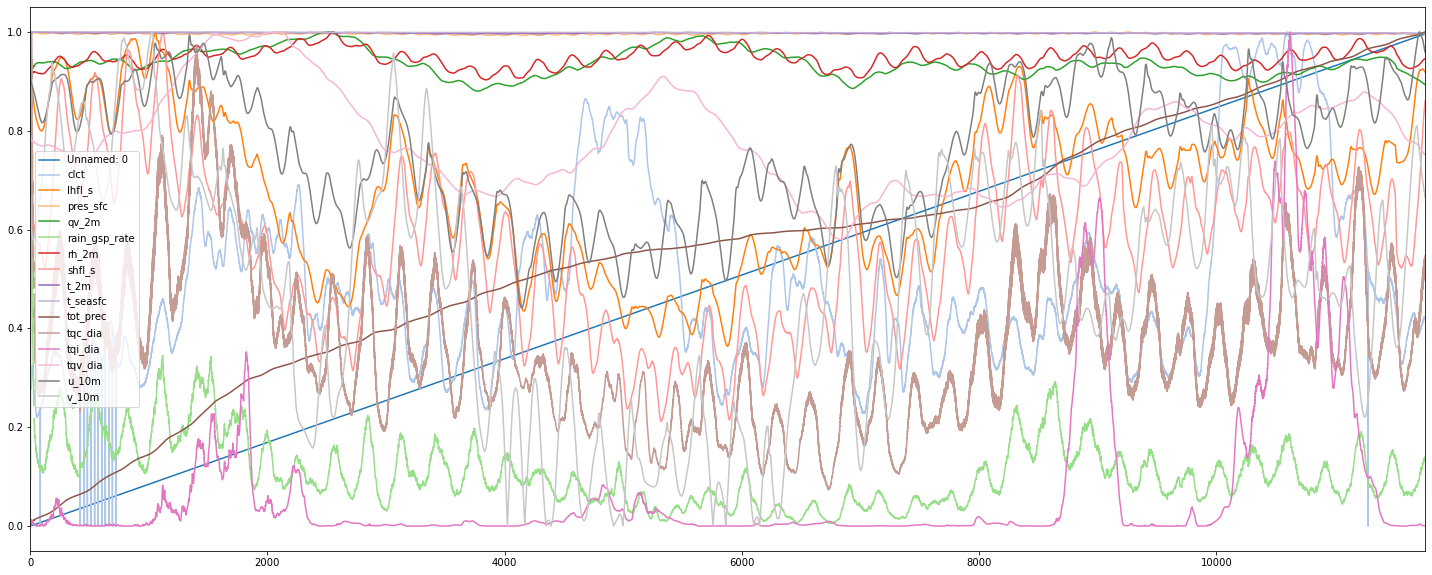

Function 'crazy_2dfield_overview' executed in 0.8797s


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

@function_timer
def crazy_2dfield_overview():
    # ich hab da mal was vorbereitet:
    csv_filename = 'data/dom01_srfc_spatialmean.csv'
    dat = pd.read_csv(csv_filename)
    labels = dat.keys()
    normalised = dict()
    for var in dat:
        normalised[var] = dat[var] / np.max(np.ma.masked_invalid(np.abs(dat[var])))
    normalised = pd.DataFrame.from_dict(normalised)

    fig, ax = plt.subplots(figsize=(25, 10))
    cmap = plt.get_cmap('tab20')
    for i, var in enumerate(normalised):
        ax.plot(np.abs(normalised[var]), label=labels[i], color=cmap(i))

    ax.legend()
    ax.set_xlim(0,11760)
    plt.show()

crazy_2dfield_overview()

There is a lot of data.... But:

# What do we want to look at?

Bony et al. (2020) identified near-surface wind speed and the strength of the lower-tropospheric stability to discriminate environments associated with different meso scale cloud pattern. Schulz et al. (2021) link each mesoscale pattern with a variable: *sugar* with weak tropical winds, *fish* with convergence, *gravel* with strong winds combined with strong subsidence and *flowers* with stronger stability.

Now what do we look for in our model output? 
 * *surface wind speed*: we have zonal and meridional wind strength in the surface output. the absolute wind strength can easily be computed as a vector product.
 * *subsidence*: Schulz et al. (2021) used the vertical wind speed at 500 hPa. The 3D fields are written in fixed height levels and these do not reach as high up as 500 hPa. Instead we will use the uppermost model level for now. It is thus the mean vertical wind speed at the uppermost model level.
 * *stability*: A common measure is the lower tropospheric stability (LTS) which is the gradient in dry potential temperture between 700 hPa and the surface ($\theta_{700} - \theta_0$). A more sophisticated predictor might be *estimated inversion strength* (EIS) as discussed e.g. by Marquet & Bechtold (2020).
 * *divergence*: It is a bit unclear to me if this measure makes sense without a reference point. Schulz et al. (2021) write of: *"divergence at 950 hPa relative to identified pattern centers composited by 20 × 20° domains around each identified pattern."* and display *"frequency of events with convergence larger than $10^{−6} s^{−1}$"* (in Figure 13).

##### References

Bony, S., Schulz, H., Vial, J., & Stevens, B. (2020). Sugar, gravel, fish, and flowers: Dependence of mesoscale patterns of trade‐wind clouds on environmental conditions. *Geophysical Research Letters*, 47(7), e2019GL085988.

Marquet, P., & Bechtold, P. (2020). A new estimated inversion strength (EIS) based on the moist-air entropy. Research activities in Earth system modelling. *Working Group on Numerical Experimentation. Report No50*. WCRP Report No12/2020. Ed. E. Astakhova, WMO, Geneva, 50, 4-07.

Schulz, H., Eastman, R., & Stevens, B. (2021). Characterization and evolution of organized shallow convection in the downstream North Atlantic trades. *Journal of Geophysical Research: Atmospheres*, 126(17), e2021JD034575.

In [17]:
# import eurec4a
# import xarray as xr
# import matplotlib.pyplot as plt
# import pandas as pd
# from time import time as ttiimmee # to avoid name conflicts....
# import numpy as np

# def timer_func(func):
#     # This function shows the execution time of 
#     # the function object passed
#     def wrap_func(*args, **kwargs):
#         t1 = ttiimmee()
#         result = func(*args, **kwargs)
#         t2 = ttiimmee()
#         print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
#         return result
#     return wrap_func

# @timer_func
# def create_spatial_mean_time_series(dataset):
#     cell_mean = {}
#     print(f'calculating mean time series ({len(dataset)} vars):',end='')

#     for i, var in enumerate(list(dataset)):
#         print(' .',end='')
#         cell_mean[var] = dataset[var].mean(dim='cell').values

#     labels = [dataset[var].long_name for var in dataset]
#     print('done')
#     return cell_mean

# @timer_func
# def create_spatial_mean(dataset, var, timelist):
#     print(var)
#     series = dataset[var].mean(dim='cell')
#     times  = series.time.values
#     series = series.values
#     out = []
#     for i,e in enumerate(series):
#         if times[i] in timelist: out.append(e)
#     return out



# cat = eurec4a.get_intake_catalog()
# srfc = cat.simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()

# cell_mean = create_spatial_mean_time_series(srfc)

# dat = pd.DataFrame.from_dict(cell_mean)
# filename = 'dom01_srfc_spatialmean.csv'
# dat.to_csv(filename)
# print(f'saved as: {filename}')

output of above cell (if deleted by rerun):
```
calculating mean time series (15 vars): . . . . . . . . . . . . . . .done
Function 'create_spatial_mean_time_series' executed in 2705.0618s
saved as: dom01_srfc_spatialmean-02.csv
```

The [`xarray` function `align`](https://docs.xarray.dev/en/v0.10.4/generated/xarray.align.html) is probably the cleaner way to go for subsampling the 2d data to fit the 3d time steps. So lets do this again:

In [22]:
import eurec4a
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def find_nearest(array, value):
    # modified from https://stackoverflow.com/a/2566508
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# this is still a somewhat shitty solution (it has a for loop)
@function_timer
def get_x_near_y_value(x, y, value):
    level = []
    for i,t in enumerate(x.time.values):
        idx = find_nearest(x.isel(time=i).mean(dim='cell').values, value)
        # print(idx, prs.isel(time=i).isel(height=idx).mean(dim='cell').values, thv.isel(time=i).isel(height=idx).mean(dim='cell').values )
        # t7 = 
        level.append(y.isel(time=i).isel(height=idx).mean(dim='cell').values)
        # theta.isel(time=t).values[find_nearest(prs.isel(time=t).values, 70000)],
    return level

def fetch_data(dom='DOM01'):
    cat = eurec4a.get_intake_catalog()
    dat_2d = cat.simulations.ICON.LES_CampaignDomain_control[f'surface_{dom}'].to_dask()
    dat_3d = cat.simulations.ICON.LES_CampaignDomain_control[f'3D_{dom}'].to_dask()
    # merge data while downsampling 2D data to coarser 3D temporal resolution
    dat = xr.merge(xr.align(dat_2d,dat_3d))
    return dat

def add_diagnostics(dat):
    # assign new diagnostics
    dat = dat.assign(w_500=lambda x: x.w.isel(height=0))
    dat = dat.assign(theta_0=lambda x: x.theta_v.isel(height=67))
    dat = dat.assign(wind=lambda x: np.sqrt(np.power(x.u_10m,2) + np.power(x.v_10m,2)))
    dat["theta_700"]=(['time'],  get_x_near_y_value(dat['pres'], dat['theta_v'], 7000))
    dat['lts'] = dat['theta_700'] - dat['theta_0'] # lower tropospheric stability, based on gradient in potential temperature
    
    # compute domain means
    dat = dat.assign(mean_w_500=lambda x: x.w_500.mean(dim='cell'))
    dat = dat.assign(mean_t_seasfc=lambda x: x.t_seasfc.mean(dim='cell'))
    dat = dat.assign(mean_wind=lambda x: x.wind.mean(dim='cell'))
    dat['mean_lts'] = dat['lts'].mean(dim='cell')
    dat['mean_clct'] = dat['clct'].mean(dim='cell')
    return dat

# dat = fetch_data()
dat = add_diagnostics(fetch_data())
dat

Function 'get_x_near_y_value' executed in 652.7877s


<xarray.Dataset>
Dimensions:        (time: 328, cell: 4528560, height: 68, bnds: 2)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-09T12:00:00 ... 2020-02-19T0...
  * height         (height) float64 83.0 84.0 85.0 86.0 ... 148.0 149.0 150.0
Dimensions without coordinates: cell, bnds
Data variables: (12/37)
    clct           (time, cell) float32 dask.array<chunksize=(1, 262144), meta=np.ndarray>
    lhfl_s         (time, cell) float32 dask.array<chunksize=(1, 262144), meta=np.ndarray>
    pres_sfc       (time, cell) float32 dask.array<chunksize=(1, 262144), meta=np.ndarray>
    qv_2m          (time, cell) float32 dask.array<chunksize=(1, 262144), meta=np.ndarray>
    rain_gsp_rate  (time, cell) float32 dask.array<chunksize=(1, 262144), meta=np.ndarray>
    rh_2m          (time, cell) float32 dask.array<chunksize=(1, 262144), meta=np.ndarray>
    ...             ...
    lts            (time, cell) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    mean_w_500     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_t_seasfc  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_wind      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_lts       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mean_clct      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Hauke Schulz (m300408) on l30466 (Linux 4.18.0-305....
    history:              /work/mh0010/m300408/DVC-test/icon-aes/bin/icon at ...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  99
    references:           see MPIM/DWD publications
    source:               icon-nwp\tgit@gitlab.dkrz.de:icon/icon-nwp.git@7e23...
    title:                ICON simulation
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140

### Adding a organisation proxy

Jule has used this variance measure (`Q4 - Q1`) as a proxy for organisation. It was proposed by Yamaguchi in Narenpitak et al. (2021).

##### Reference 
Narenpitak, P., Kazil, J., Yamaguchi, T., Quinn, P., & Feingold, G. (2021). From sugar to flowers: A transition of shallow cumulus organization during ATOMIC. *Journal of Advances in Modeling Earth Systems*, 13, e2021MS002619. https://doi.org/10.1029/2021MS002619 

In [23]:
def calc_Q4_Q1_binned_diff(twp):
    # as proposed in https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021MS002619
    twp_Qs = twp.quantile([0, 0.25, 0.5, 0.75, 1], dim = 'cell')
    twp_Q1 = twp.where((twp>twp_Qs.sel(quantile=0)) & (twp<=twp_Qs.sel(quantile=0.25))).mean(dim='cell')
    twp_Q4 = twp.where((twp>twp_Qs.sel(quantile=0.75)) & (twp<=twp_Qs.sel(quantile=1))).mean(dim='cell')
    return twp_Q4-twp_Q1


ds_coarse = dat.coarsen(cell=4**5, boundary = 'pad').mean()   ## coarse graining to mesoscale
dat['mean_organisation'] = calc_Q4_Q1_binned_diff((ds_coarse.tqv_dia + ds_coarse.tqc_dia).chunk(dict(cell=-1)))  ## +tqr

In [24]:
# delete some of the fields
delete_list = list(dat)
for item in list(dat):
    if 'mean' in item: delete_list.remove(item)
dat_reduced = dat.drop_vars(delete_list)

Function 'print_correlation' executed in 815.9494s


(<Figure size 1368x1080 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlation Matrix'}>)

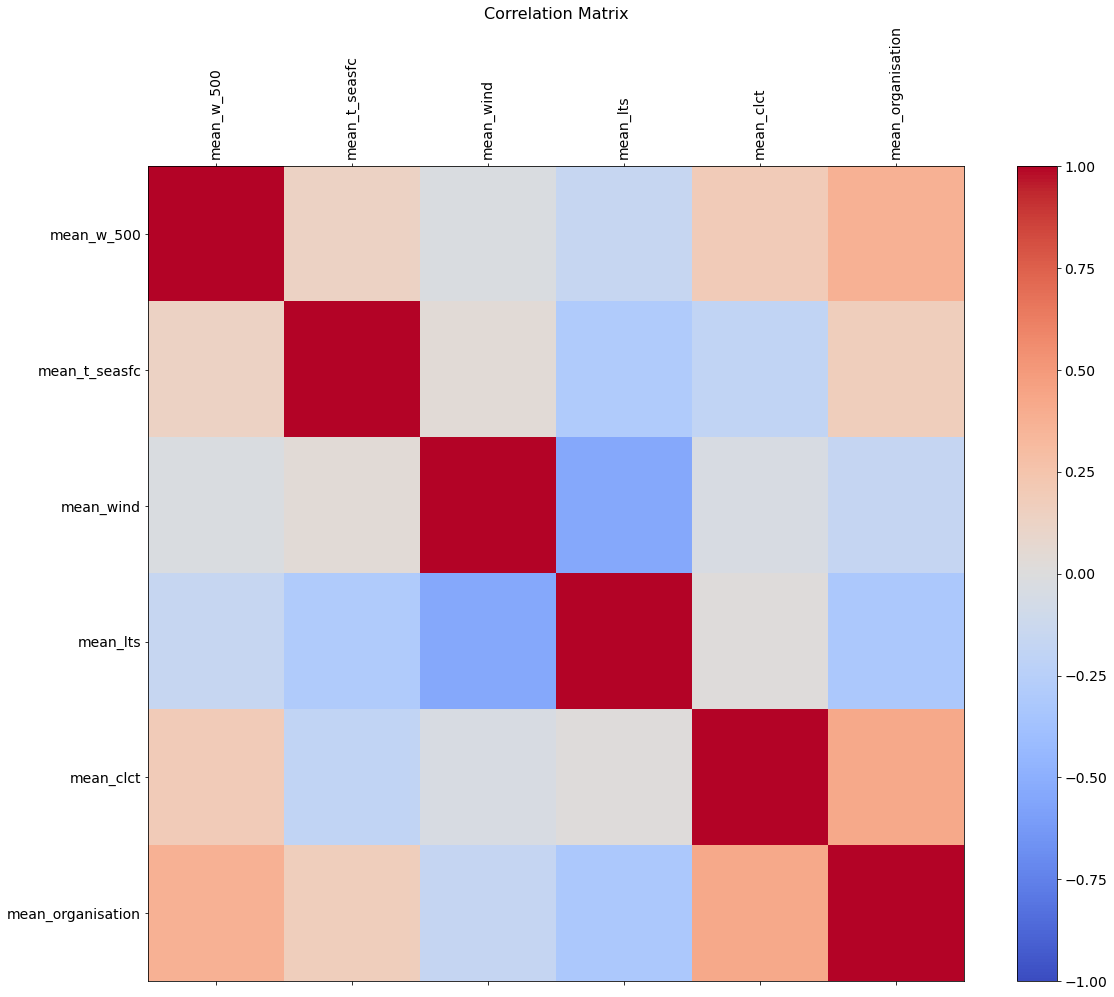

In [25]:
@function_timer
def print_correlation(dat, cmap='coolwarm'):
    normalised = dict()
    for var in dat:
        normalised[var] = dat[var] / np.max(np.ma.masked_invalid(np.abs(dat[var])))
    normalised = pd.DataFrame.from_dict(normalised)
    labels = normalised.keys()
    # labels = [dat[var].long_name for var in dat]

    fig, ax = plt.subplots(figsize=(19, 15))
    cmap = plt.get_cmap(cmap)
    # cmap = plt.get_cmap('RdBu')
    mshow = ax.matshow(normalised.corr(), cmap=cmap, vmin=-1.0, vmax=1.0)
    ax.set_xticks(range(len(labels)), labels, fontsize=14, rotation=90)
    ax.set_yticks(range(len(labels)), labels, fontsize=14)

    cb = fig.colorbar(mshow, orientation='vertical')
    cb.ax.tick_params(labelsize=14)

    ax.set_title('Correlation Matrix', fontsize=16);
    return fig, ax

print_correlation(dat_reduced)

### We are still missing divergence

I have dodged divergence so far. It is a somewhat more complicated measure. Luckily there is documentation on the [easy gems repository](https://easy.gems.dkrz.de/Processing/playing_with_triangles/Gradient_on_Triangular_Grid/calculating_gradient.html) on how to compute gradients on a triangular grid. I will have to read that :sob:

## Overview over lateral boundary conditions

In [ ]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

import xarray as xr
import numpy as np
from function_timer import function_timer 
import boundary_tools as bdt

import matplotlib.pyplot as plt
import plot_utils as pu

@function_timer
def get_quantile_profiles(latbc_path, quantile=0.5):
    def append_quantile_profile(profiles, files, quantile):
        data = xr.open_mfdataset(files)
        profile = data.chunk(dict(time=-1)).quantile(quantile, dim=['time','ncells'])
        profiles.append(profile)
    
    profiles = list()
    for d in [f for f in os.listdir(latbc_path) if not f.endswith('.nc')]:
        path = os.path.join(latbc_path, d)
        files = [os.path.join(path,f) for f in os.listdir(path)]
        append_quantile_profile(profiles, files, quantile)

    return xr.merge(profiles, compat='override')

def augment_profile(profile):
    return bdt.add_relative_humidity(bdt.add_prognostic_variables(profile))

def fetch_quantile(q, data_path='./data', latbc_path='/work/mh1126/m300872/unchanged/latbc'):
    f = f'latbc_q{q*100:.0f}.nc'
    if f in os.listdir(data_path):
        d = xr.open_dataset(os.path.join(data_path, f))
    else:
        d = augment_profile(get_quantile_profiles(latbc_path, quantile=q))
        d.to_netcdf(os.path.join(data_path, f))
    return d

def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def fig_boundary_conditions_radtke_like(latbc_path='/work/mh1126/m300872/unchanged/latbc'):
    quantile = dict()
    for q in [0.25,0.5,0.75]:
        quantile[q] = fetch_quantile(q, latbc_path=latbc_path)

    z = interpolate_full_level(quantile[0.5]['z_ifc'])/1000

    color = 'tab:blue'
    variables = ['theta_v', 'qv', 'RH', 'u', 'v']
    labels    = ['$\{theta}$ / K', '$q_v$ / $g kg^{-1}$', 'RH / %', 'u / $m s^{-1}$', 'v / $m s^{-1}$']
    xlims     = [(290,350), (0,0.020), (0.0,1), (-20,20), (-10, 10)]
    ylim = (0, 8)

    fig, axs = plt.subplots(1,5, figsize=(16,4))
    for ax, var, label, xlim in zip(axs, variables, labels, xlims):
        ax.fill_betweenx(z, quantile[0.25][var], quantile[0.75][var], alpha=0.2, color=color)
        ax.plot(quantile[0.50][var], z, color=color)
        ax.set_xlabel(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        pu.adjust_spines(ax, ['left', 'bottom'])
        if not ax == axs[0] : ax.set_yticklabels([])
    axs[0].set_ylabel('height / km')
    return fig, axs

fig, axs = fig_boundary_conditions_radtke_like()
fig.savefig('./img/latbc_variance.png')
fig.show()